<a href="https://www.kaggle.com/hamedetezadi/capacitive-deionization?scriptVersionId=88413416" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#Libraries

In [1]:
# import pandas as pd
# import numpy as np
# import keras
# import tensorflow as tf
# from keras import backend
# np.random.seed(1234)
# tf.random.set_seed(1234)
#get_ipython().magic('matplotlib inline')

#%tensorflow_version 2.x
import tensorflow as tf

from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AlphaDropout

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

# # user-defined libraries
# from  tf.keras.preprocessing import utilities as dp
# import utilities.performancemetrics as pm
# import utilities.simpleplots as sp

from numpy.random import seed
seed(1)

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error as mae
import math

# Data pre-peration


In [2]:
pip install openpyxl

     |████████████████████████████████| 242 kB 924 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [3]:
data = pd.read_excel('../input/capacitive-deionization-dataset/Capacitive Deionization.xlsx')
#labeled_data = data[data['Desalination(%)'].notna()]
#labeled_data = data[['Desalination(%)','EC(μmho/cm)']]
labeled_data = data[['Desalination(%)']]
labeled_data

,Desalination(%)
0,0.170
1,0.155
2,0.135
3,0.110
4,0.095
...,...
120,0.186
121,0.182
122,0.175
123,0.168


In [4]:
Xn = data.drop(['Desalination(%)','EC(μmho/cm)'], axis=1)
Xn = Xn.fillna(labeled_data.mean())
Xn  = Xn[[x for x in Xn.columns][0:3]] #Correct
Yn = labeled_data
# x_train_mlp, x_test_mlp, y_train_mlp, y_test_mlp = train_test_split(Xn, Yn, test_size=0.2, random_state=40)
#Yn1=Yn["Desalination(%)"]
#Yn2=Yn["EC(μmho/cm)"]
Xn
# print(x_train_mlp.shape)
# print(y_train_mlp.shape)

,volt(V),concentrate(ppm),feed rate(ml/min)
0,0.8,1000,10
1,0.8,1000,20
2,0.8,1000,30
3,0.8,1000,40
4,0.8,1000,50
...,...,...,...
120,1.6,5000,10
121,1.6,5000,20
122,1.6,5000,30
123,1.6,5000,40


In [5]:

# Divide the data into train, valid, and test
X_train, X_test, y_train, y_test = train_test_split(Xn, 
                                                    Yn,
                                                    test_size=DATA_SPLIT_PCT,
                                                    random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      y_train,
                                                      test_size=DATA_SPLIT_PCT,
                                                      random_state=SEED)
# X_train, X_valid, y_train, y_valid = train_test_split(x_train_mlp,
#                                                       y_train_mlp,
#                                                       test_size=0.2,
#                                                       )
print(X_train.shape)
print(y_train.shape)

(80, 3)
(80, 1)


In [6]:
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train, scaler)
X_valid_scaled = scaler.transform(X_valid, scaler)
X_test_scaled = scaler.transform(X_test, scaler)

In [7]:
# import matplotlib.pyplot as plt
# plt.plot(Yn)
# plt.ylabel('Desalination(%)')
# plt.show()
# set([x for x in Yn])

In [8]:
# Adding a Y-Axis Label to the Secondary Y-Axis in Matplotlib
# importing the libraries
# import numpy as np
# import matplotlib.pyplot as plt
 
# # creating data for plot
# # data arrangement between 0 and 50
# # with the difference of 2
# # x-axis
# x = np.arange(0, 50, 2)
 
# # y-axis values
# y1 = x**2
 
# # secondary y-axis values
# y2 = x**3
 
# # plotting figures by creating aexs object
# # using subplots() function
# fig, ax = plt.subplots(figsize = (10, 5))
# plt.title('Example of Two Y labels')
 
# # using the twinx() for creating another
# # axes object for secondary y-Axis
# ax2 = ax.twinx()
# ax.plot(x, y1, color = 'g')
# ax2.plot(x, y2, color = 'b')
 
# # giving labels to the axises
# ax.set_xlabel('x-axis', color = 'r')
# ax.set_ylabel('y1-axis', color = 'g')
 
# # secondary y-axis label
# ax2.set_ylabel('Secondary y-axis', color = 'b')
 
# # defining display layout
# plt.tight_layout()
 
# # show plot
# plt.show()

# The Model

In [9]:
def baseline_model(inp_size, x, y):
  # create model
  model = Sequential()
  #model.add(Dense(neurons, input_dim=inp_size, kernel_initializer='normal', activation='relu'))
  model.add(Dense(64,input_dim=inp_size, kernel_initializer='normal',activation='relu',name='layer_1'))
  model.add(Dense(32, kernel_initializer='normal',activation='relu',name='layer_2'))
  #model.add(Dense(2, kernel_initializer='normal', activation='relu',name='layer_2'))
  model.add(Dense(1, kernel_initializer='normal', activation='relu',name='output'))
  # Compile model
  model.compile(loss='mean_squared_error', optimizer='adam')
  history=model.fit(x,
            y,
                    batch_size=10,
                    epochs=100,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=1).history
  
  return model,history

In [10]:
model,history = baseline_model(3, X_train_scaled,y_train)
for i in history.keys():
  print(i)
loss_values = history['loss']
val_loss_values = history['val_loss']
#accuracy = history['accuracy']
#val_accuracy = history['val_accuracy']



User settings:

   KMP_AFFINITY=granularity=fine,noverbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER

Epoch 1/100
8/8 [==============================] - 1s 27ms/step - loss: 0.0241 - val_loss: 0.0152
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0162 - val_loss: 0.0076
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0079 - val_loss: 0.0018
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 5.8154e-04 - val_loss: 4.5386e-04
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 5.5573e-04 - val_loss: 4.4517e-04
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 4.9580e-04 - val_loss: 5.5542e-04
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 4.5610e-04 - val_loss: 6.5053e

#Assesment

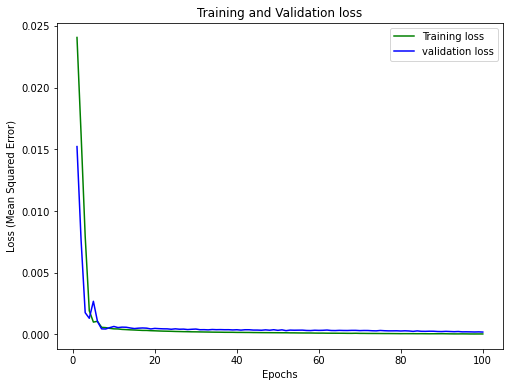

In [11]:
epochs = range(1,101)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.show()

In [12]:
print("Train_Pred")
pred_train= model.predict(X_train_scaled)
print('Training RMSE:', np.sqrt(mean_squared_error(y_train,pred_train)))
print('Training MSE:', mean_squared_error(y_train,pred_train))
print('Training R2:', r2_score(y_train,pred_train))
print('Training MAE:', mae(y_train,pred_train))
print("Test_Pred")
pred_test= model.predict(X_test_scaled)
print('Test RMSE:', np.sqrt(mean_squared_error(y_test,pred_test)))
print('Test MSE:', mean_squared_error(y_test,pred_test))
print('Test R2:', r2_score(y_test,pred_test))
print('Test MAE:', mae(y_test,pred_test))
print("Model_Pred")
# pred= model.predict(Xn)
# print('Total RMSE:', np.sqrt(mean_squared_error(Yn,pred))) 
# print('Total MSE:', mean_squared_error(Yn,pred)) 
# print('Total R2:', r2_score(Yn,pred))
# print('Total MAE:', mae(Yn,pred))
model.summary()



Train_Pred
Training RMSE: 0.006000777724107444
Training MSE: 3.6009333294144115e-05
Training R2: 0.9184122833628103
Training MAE: 0.00467046526968479
Test_Pred
Test RMSE: 0.01090468849244697
Test MSE: 0.00011891223111730538
Test R2: 0.8221058893739526
Test MAE: 0.009067861382166545
Model_Pred
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 64)                256       
_________________________________________________________________
layer_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 2,369
Trainable params: 2,369
Non-trainable params: 0
_________________________________________________________________


Loss: 0.0002313185000713206
Coefficients: 
 [[ 0.01053078  0.00263083 -0.01569324]]
Residual sum of squares: 0.00
Variance score: 0.65
      Actual  Prediction
0   0.095000    0.115776
1   0.161667    0.150069
2   0.158333    0.142409
3   0.172500    0.176640
4   0.128750    0.152953
5   0.135000    0.135455
6   0.100000    0.123436
7   0.206667    0.198145
8   0.121250    0.144235
9   0.150000    0.137281
10  0.135000    0.157312
11  0.173333    0.158787
12  0.151000    0.123081
13  0.142500    0.129621
14  0.167500    0.165679
15  0.170000    0.163852
16  0.148333    0.131448
17  0.195000    0.186126
18  0.179000    0.186478
19  0.163333    0.146768
20  0.145000    0.146416
21  0.131250    0.156254
22  0.165000    0.161320
23  0.140000    0.143115
24  0.175000    0.177760


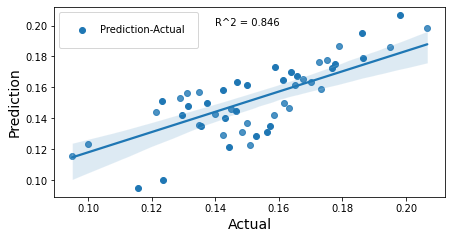

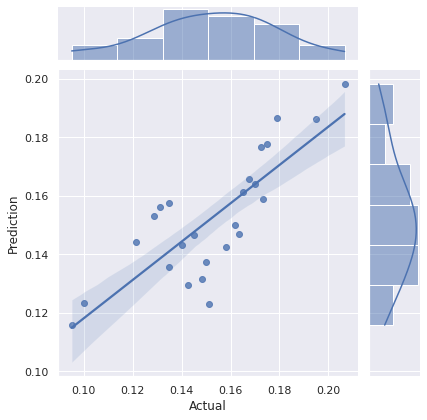

In [13]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as rmse
reg = LinearRegression().fit(X_test_scaled, y_test)
predictions = reg.predict(X_test_scaled)


fig, ax = plt.subplots(figsize=(7, 3.5))

ax.scatter(predictions, y_test)
plt.text(0.14,0.2,'R^2 = 0.846')
ax.set_xlabel('prediction', fontsize=14)
ax.set_ylabel('Target', fontsize=14)
ax.legend(["Prediction-Actual"],loc='upper left',borderpad=1.3,handlelength=2,facecolor='white')




loss = rmse(y_test, predictions)
print('Loss:', loss)



# The coefficients
print('Coefficients: \n', reg.coef_)

# The mean square error
print("Residual sum of squares: %.2f" % np.mean((reg.predict(X_test_scaled) - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % reg.score(X_test_scaled, y_test))


#print(y_test.to_numpy())
#arr = np.dstack((y_test.to_numpy(), predictions))
#print(arr[:,0])
#print(predictions[:,0].shape) 
#print(reg.predict(X_test_scaled).shape)
df = pd.DataFrame(predictions, columns = ['Pred'])
y_test=y_test.reset_index(drop=True)
df=df.reset_index(drop=True)
result = pd.concat([y_test, df], axis=1, ignore_index=True)
result.columns=['Actual','Prediction']
print(result)
import seaborn as sns
sns.set_theme(color_codes=True)
sns.regplot(x="Actual", y="Prediction", data=result)
sns.jointplot(x="Actual", y="Prediction", data=result, kind="reg");




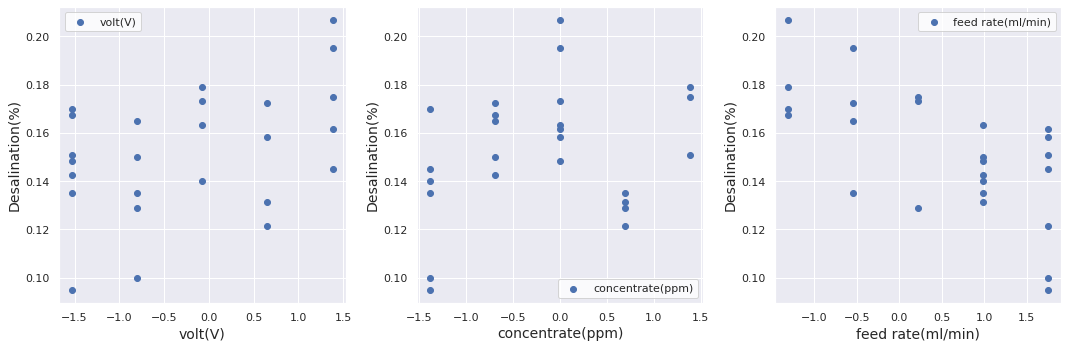

In [14]:
import seaborn as sns

X_test_df = pd.DataFrame(X_test_scaled, columns = Xn.columns)

fig, ax = plt.subplots(1,3,figsize=(15, 5))

for i,x in enumerate(X_test_df.columns):
    ax[i].scatter(X_test_df[[x]], y_test, label=x)
    ax[i].set_xlabel(x, fontsize=14)
    ax[i].set_ylabel('Desalination(%)', fontsize=14)
    ax[i].legend(facecolor='white', fontsize=11)

plt.tight_layout()

**Ok, now your turn, please do this calcultion with two output---> EC and Desalination**